# Feature Selecection

In [177]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

# Import Preporcessed Data

In [178]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date" , inplace=True)

# Add prediction target

In [179]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["AVG_Range"] , "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["AVG_Range"] , "TARGET"] = 0

In [180]:
# Check for NAN
nan_location = np.where(np.isnan(df))

In [181]:
# Fill NaNs
df["TARGET"].fillna(0,inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-09,-0.001330,-0.004010,-0.015793,27583.677734,0.516718,-0.012580,0.025159,3.185758,55.925229,0.910373,...,0,0.066139,0.022740,-0.001207,0.013032,0.078333,0.000796,0.005657,0.066791,0.0
2023-10-10,-0.012360,-0.009776,-0.000033,27391.019531,-0.169418,-0.006985,0.015171,3.156683,53.114576,0.949743,...,1,0.061605,0.022806,-0.012580,0.025159,0.066139,-0.001207,0.013032,0.078333,1.0
2023-10-11,-0.007145,-0.008722,-0.027125,26873.320312,0.368456,-0.018900,0.034374,3.078116,46.370587,0.873029,...,2,0.068624,0.022677,-0.006985,0.015171,0.061605,-0.012580,0.025159,0.066139,0.0
2023-10-12,-0.018939,-0.020116,-0.000105,26756.798828,-0.311779,-0.004336,0.013673,3.059839,44.986082,0.970143,...,3,0.037634,0.021383,-0.018900,0.034374,0.068624,-0.006985,0.015171,0.061605,0.0
2023-10-13,-0.004481,0.006361,0.004820,26862.375000,0.614549,0.003946,0.015228,3.076439,46.543471,1.034619,...,4,0.026290,0.021122,-0.004336,0.013673,0.037634,-0.018900,0.034374,0.068624,0.0


# Train - Test SPLIT

In [182]:
# REMOVE UNWANTED COLUMNS (dont put information about the future in your data other than the target)
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets" , "Open" ], inplace=True)

In [183]:
# Split into Learning (X) and Target (y) data
X = df_tts.iloc[: , : -1 ]
y = df_tts.iloc[: ,   -1 ]

In [184]:
# Train Test Split
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.2 , random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1080, 18)
Shape of y_train: (1080,)


# Build Initial Model
- find the useful features

In [185]:
# Select type of model to optimize for
is_binary = True
is_optimize_for_precision = True

In [186]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error","logloss",eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror","mlogloss",eval_metric]

In [187]:
# Refine Eval Metric
if is_binary and is_optimize_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimize_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [188]:
# Build First Classifier Model
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Find Hyper-Parameters
- find optimal
    - estimators 
    - learning rate 
    - maximum depth
    - gamma

In [189]:
# Provide Grid for Hyper-Parameterss
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [190]:
# preform Random Search for Best Hyper Params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train,y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]


# DISPLAY RESULTS
print("Recommended params >>" , f"ne: {ne}", f"lr: {lr}", f"md: {md}", f"gm: {gm}")



# SAVE TO JSON FOR XGBOOST
import json
data = { "ne": ne, "lr": lr, "md": md, "gm": gm}
with open('./data/hyperparametertuning.json', 'w') as f:
    json.dump(data, f)

Recommended params >> ne: 100 lr: 0.02 md: 1 gm: 0


# Train Model (xg-boost)

In [191]:
# Build First Classifier Model
classifier_1 = XGBClassifier(
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md ,
    gamma = gm,
    objective=objective,
    booster="gbtree",
    # eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Fit Model with Data

In [192]:
eval_set = [(X_train,y_train)]

classifier_1.fit(
    X_train,
    y_train ,
    eval_metric = eval_metric_list,
    eval_set = eval_set,
    verbose = False
)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

# Performance Evaluation (quick overview)

In [193]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)

train_yhat[:5]

array([0, 0, 0, 0, 0])

In [194]:
# Cross validate
crossValidation  = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)

In [195]:
# Training Results 
train_results = cross_val_score(
    classifier_1,X_train,y_train,scoring=scoring,cv=crossValidation , n_jobs= 1
)

In [196]:
# Review Results 
print("Average Accuracy K-Fold: ", round(train_results.mean() , 2))
print("STD Deviation K-Fold: "   , round(train_results.std() , 2))
print("Precision score 0: "      , precision_score(y_train , train_yhat , average=None)[0])
print("Precision score 1: "      , precision_score(y_train , train_yhat , average=None)[1])

Average Accuracy K-Fold:  0.68
STD Deviation K-Fold:  0.15
Precision score 0:  0.6356589147286822
Precision score 1:  0.8125


# **************************** 
# **** Feature Seletion **** 
- a feature about xg-boost is that it can tell you wht features helped with making predictions

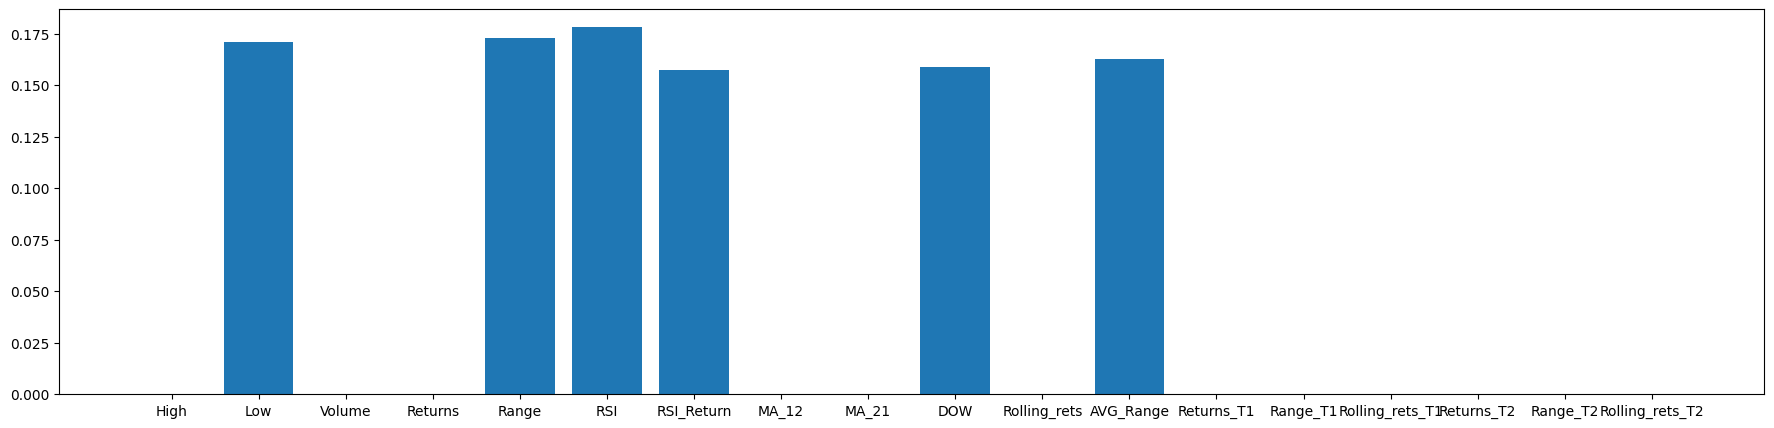

In [197]:
# RELEVANCY - features that influenced ai decisions 
fig = plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels , importance_features)
plt.show()

In [198]:
# SELECT BEST FEATURES
mean_of_feature_importance = importance_features.mean()
recommended_feature_labels = []
recommended_feature_score = []
for i in range(0, len(importance_features) , 1) :
    if importance_features[i] > mean_of_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(importance_features[i])


# save output for future reference
with open('./data/feature_selection_output.json', 'w') as f:
    json.dump(recommended_feature_labels, f)

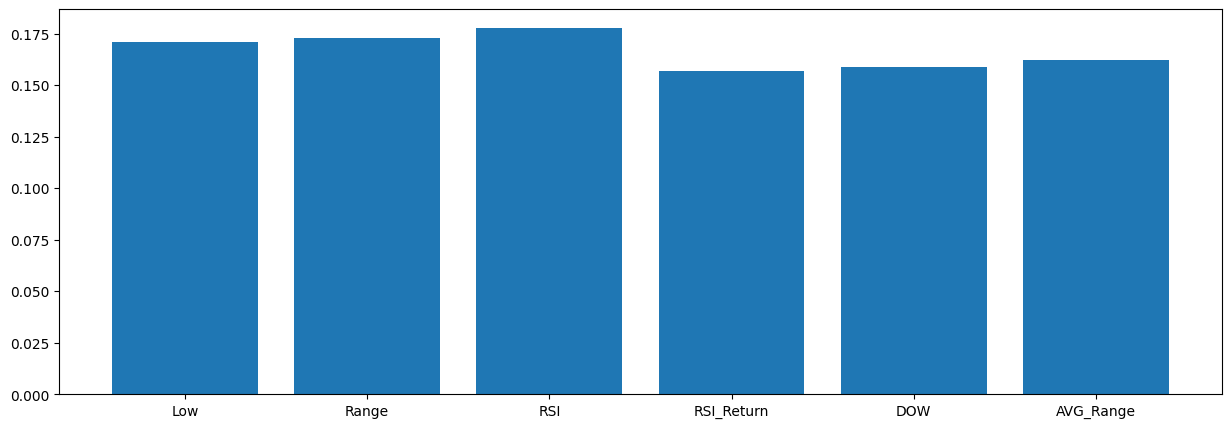

In [199]:
# plot recommended features
fig = plt.figure(figsize=(15,5))
plt.bar(recommended_feature_labels , recommended_feature_score)
plt.show()

*These features had the most influence on the ai*